In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import defaultdict, Counter
from konlpy.tag import Okt
from datetime import datetime
import os
from wordcloud import WordCloud

In [34]:
# ───────────── 설정 ─────────────
# rcParams['font.family'] = 'NanumSquare'
rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

DATA_DIR = "../01_데이터수집/data/제20대_대선_테마주/"
PAXNET_PATH = "../01_데이터수집/비정형데이터/faxnet_20/팍스넷_20대_대선_테마주_크롤링_20250627.csv"
NAVER_PATH = "../01_데이터수집/비정형데이터/stock_community/output/csv/제20대_대선_테마주/"
POS_PATH = "../03_모델링/sentiment_dictionary/final_positive_dict.csv"
NEG_PATH = "../03_모델링/sentiment_dictionary/final_negative_dict.csv"

FIXED_START = datetime(2022, 2, 5)
FIXED_END = datetime(2022, 3, 16)

In [35]:
# ───────────── 데이터 로딩 ─────────────

####################### 팍스넷 데이터 ##################################
paxnet_df = pd.read_csv(PAXNET_PATH)
paxnet_df["날짜"] = pd.to_datetime(paxnet_df["날짜"])
#####################################################################



####################### 네이버 종토방 데이터 #############################
csv_files = [f for f in os.listdir(NAVER_PATH) if f.endswith(".csv")]   # 경로 내 csv 파일 목록 가져오기

dataframes = [] # concat 저장용

# 각 CSV 파일 읽어서 리스트에 추가
for file in csv_files:
    file_path = os.path.join(NAVER_PATH, file)
    try:
        df = pd.read_csv(file_path)
        df['filename'] = file  # 어떤 파일에서 왔는지 표시
        dataframes.append(df)
    except Exception as e:
        print(f"파일 읽기 오류: {file_path} → {e}")

naver_df = pd.concat(dataframes, ignore_index=True) # concat
naver_df['article_date'] = pd.to_datetime(naver_df['article_date'])
#####################################################################



###################### 긍정, 부전 사전 #################################
positive_df = pd.read_csv(POS_PATH)
negative_df = pd.read_csv(NEG_PATH)
sentiment_dict = {
    **dict(zip(positive_df["단어"], positive_df["최종점수"])),
    **dict(zip(negative_df["단어"], negative_df["최종점수"]))
}
#####################################################################

okt = Okt()  # 형태소 분석기 인스턴스 생성

In [37]:
# ───────────── 데이터 전처리 ─────────────
naver_selected_df = naver_df[["stock_name", "article_date", "article_title", "article_content"]].copy()
naver_selected_df.rename(columns={
    "stock_name": "종목명",
    "article_date": "날짜",
    "article_title": "제목",
    "article_content": "내용"
}, inplace=True)

paxnet_selected_df = paxnet_df[['종목명', '날짜', '제목', '내용']].copy()

stock_df = pd.concat([naver_selected_df, paxnet_selected_df], ignore_index=True)    # 데이터 병합
stock_df.sort_values(by='날짜', inplace=True)   # datetime 순서로 정렬

In [38]:
# ───────────── 감성 점수 계산 함수 ─────────────
def compute_sentiment_by_date(df, stock_name, sentiment_dict, okt):
    score_by_date = defaultdict(float)
    for _, row in df[df["종목명"] == stock_name].iterrows():
        date = row["날짜"].date()
        text = f"{row['제목']} {row['내용']}"
        words = set(okt.morphs(text))
        score = sum(sentiment_dict[word] for word in words if word in sentiment_dict)
        score_by_date[date] += score
    return score_by_date

In [39]:
# ───────────── 종목별 감성 점수 및 주가 저장 ─────────────
all_stock_sentiment = {}
all_stock_prices = {}

for file_name in os.listdir(DATA_DIR):
    if not file_name.endswith(".csv"):
        continue

    file_path = os.path.join(DATA_DIR, file_name)
    price_df = pd.read_csv(file_path)
    price_df["Date"] = pd.to_datetime(price_df["Date"])
    price_df = price_df[(price_df["Date"] >= FIXED_START) & (price_df["Date"] <= FIXED_END)]

    if price_df.empty:
        continue

    stock_name = price_df["Name"].iloc[0]
    score_by_date = compute_sentiment_by_date(stock_df, stock_name, sentiment_dict, okt)

    sentiment_df = pd.DataFrame({
        "날짜": pd.to_datetime(list(score_by_date.keys())),
        "감성점수": list(score_by_date.values())
    }).sort_values("날짜")

    all_stock_sentiment[stock_name] = sentiment_df
    all_stock_prices[stock_name] = price_df

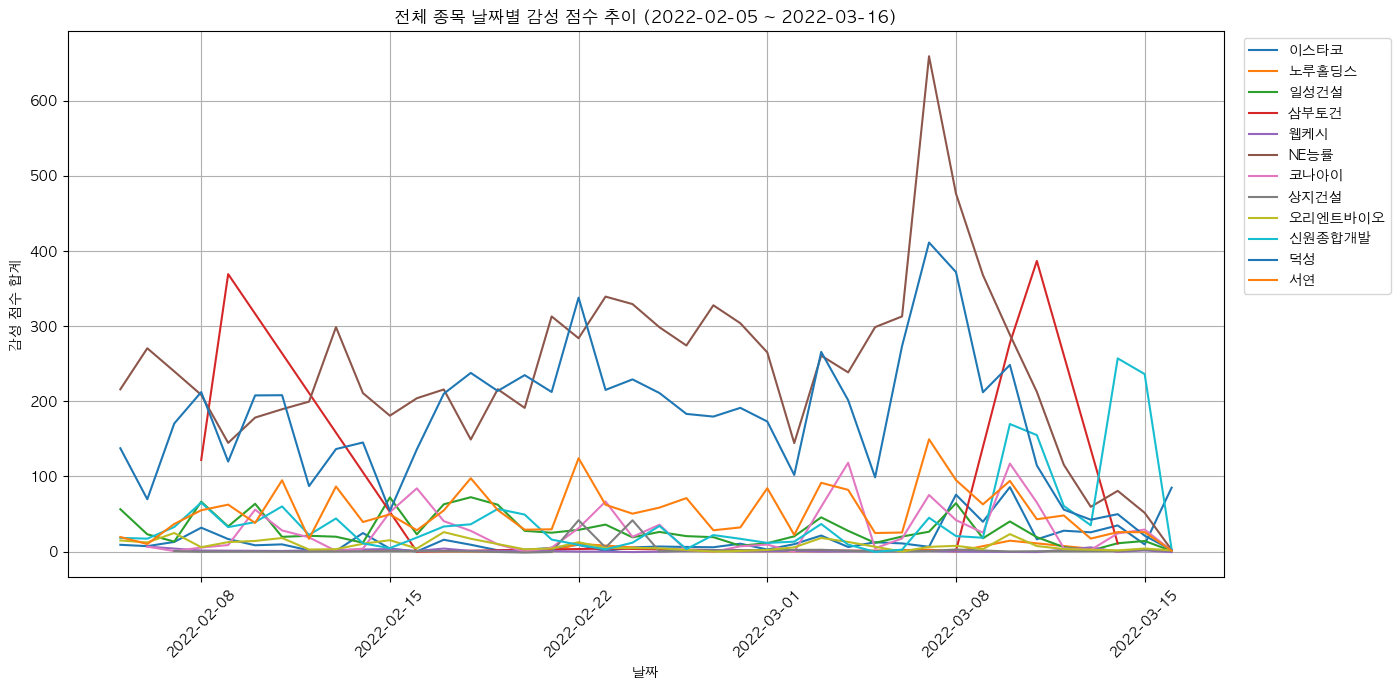

In [40]:
# ───────────── [1] 전체 종목 감성 점수 추이 ─────────────
plt.figure(figsize=(14, 7))

for stock, sentiment_df in all_stock_sentiment.items():
    filtered_sentiment = sentiment_df[
        (sentiment_df["날짜"] >= FIXED_START) &
        (sentiment_df["날짜"] <= FIXED_END)
    ]
    if filtered_sentiment.empty:
        # 날짜 축만 유지하고 y=0 값으로 대체
        plt.plot([FIXED_START, FIXED_END], [0, 0], linestyle='--', label=f"{stock} (감성 없음)")
    else:
        plt.plot(filtered_sentiment["날짜"], filtered_sentiment["감성점수"], label=stock)

plt.title("전체 종목 날짜별 감성 점수 추이 (2022-02-05 ~ 2022-03-16)")
plt.xlabel("날짜")
plt.ylabel("감성 점수 합계")
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1.0))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ───────────── [2] 종목별 감성 점수만 시각화 ─────────────
for stock_name, sentiment_df in all_stock_sentiment.items():
    filtered_sentiment = sentiment_df[
        (sentiment_df["날짜"] >= FIXED_START) &
        (sentiment_df["날짜"] <= FIXED_END)
    ]

    plt.figure(figsize=(10, 4))
    if filtered_sentiment.empty:
        plt.plot([FIXED_START, FIXED_END], [0, 0], linestyle='--', color='gray')
        plt.title(f"{stock_name}: 감성 점수 없음 (2022-02-05 ~ 2022-03-16)")
    else:
        plt.plot(filtered_sentiment["날짜"], filtered_sentiment["감성점수"],
                 marker='o', color='tab:red')
        plt.title(f"{stock_name}: 날짜별 감성 점수 추이 (2022-02-05 ~ 2022-03-16)")
    plt.xlabel("날짜")
    plt.ylabel("감성 점수")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_4255/2845004644.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[12.8565 31.8011 16.6834  8.3776  9.5943 24.6658  3.903   0.1367 15.733
  9.103   5.0263  8.9371  0.7511  5.568   6.7511 10.5023  9.8734 21.3646
  6.1559  6.3653 75.7191 85.77   16.3323 34.8206  9.5165 85.0931]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


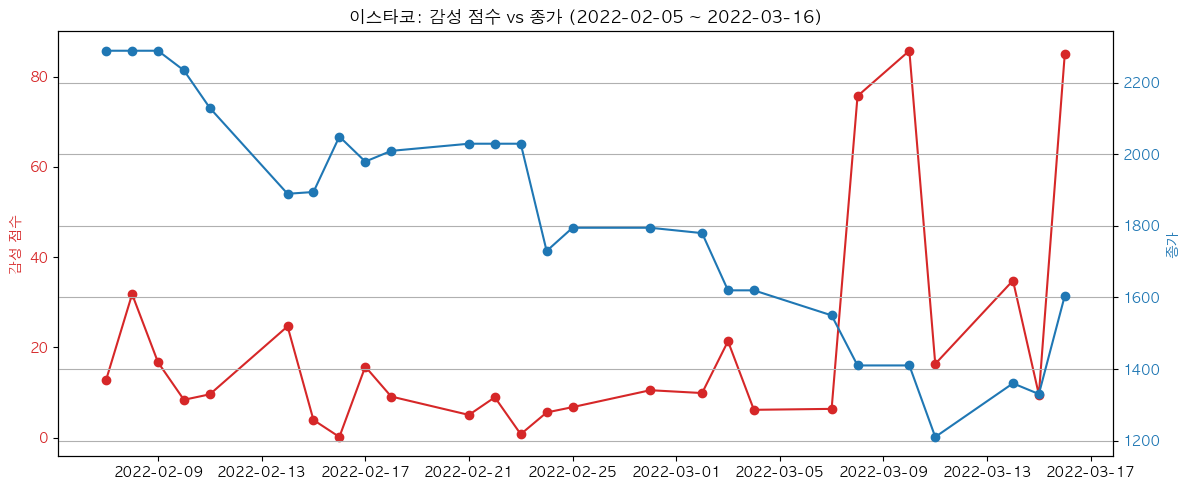

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_4255/2845004644.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.216   0.0785  0.     10.3239  0.3262  0.6785  2.5739 -0.04   14.5052
  0.26  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


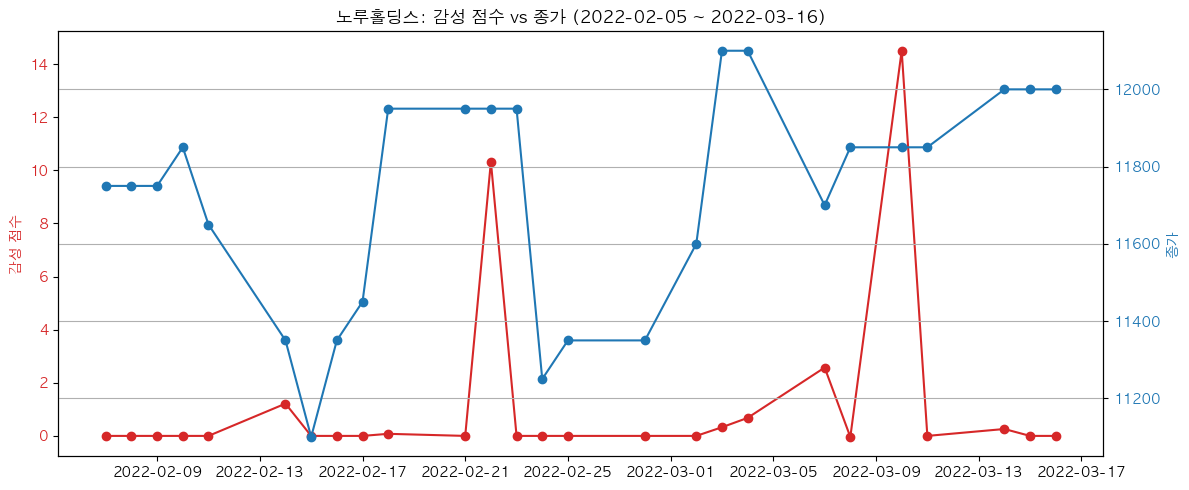

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_4255/2845004644.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[13.2701 66.3809 33.4454 63.5936 19.6033 11.785  72.0943 22.9431 62.9615
 72.3863 25.1063 28.9082 35.9366 18.9616 26.1594  7.7804 20.2826 45.5728
 27.5999 26.4373 64.3827 40.0924 19.1657 11.0813 14.1391  0.7665]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


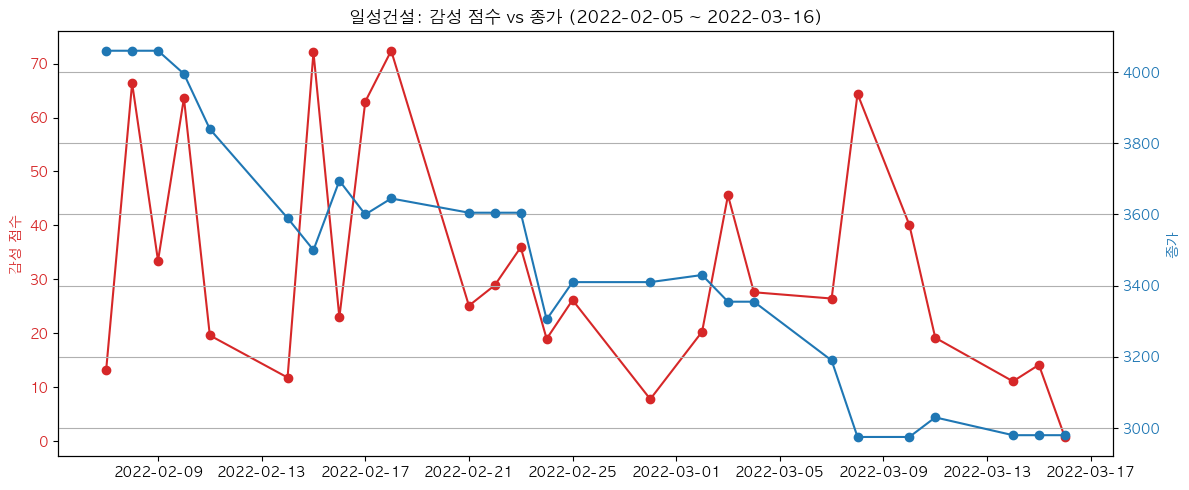

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_4255/2845004644.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[121.9597 369.3356   0.       3.9931   1.5585   1.0373   0.9994 277.5956
 386.8555  10.7533]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


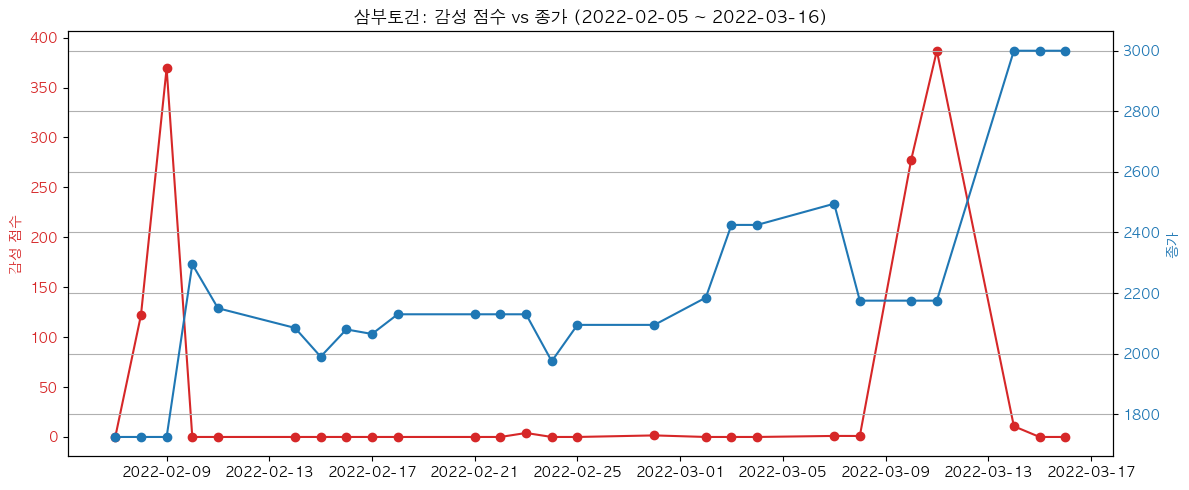

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_4255/2845004644.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.405   0.8362  3.4088  0.8194  4.0102  0.9387  0.7585  0.032  -0.04
 -0.6323  0.      0.16    0.7465  0.0453  0.68    0.0497 -0.6703 -0.2223
  1.5185 -0.68  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


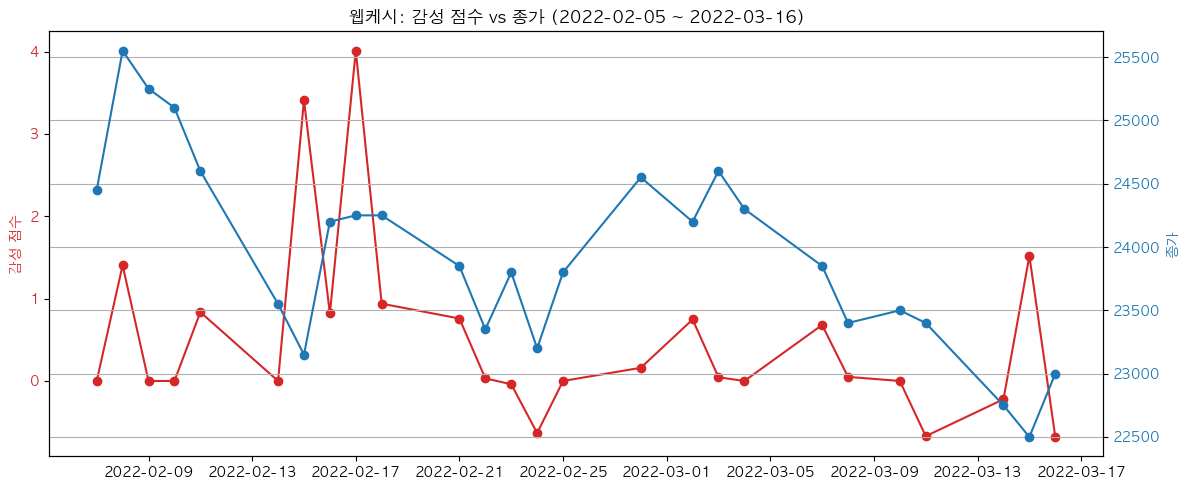

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_4255/2845004644.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[239.8749 208.6531 144.6705 178.3543 189.4768 210.9181 180.9081 204.1104
 215.7753 149.1409 312.9926 283.9769 339.385  329.4328 298.5801 303.9576
 144.4128 260.8838 238.5012 659.3311 476.4891 288.6229 212.6527  80.8533
  51.5836   2.0554]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


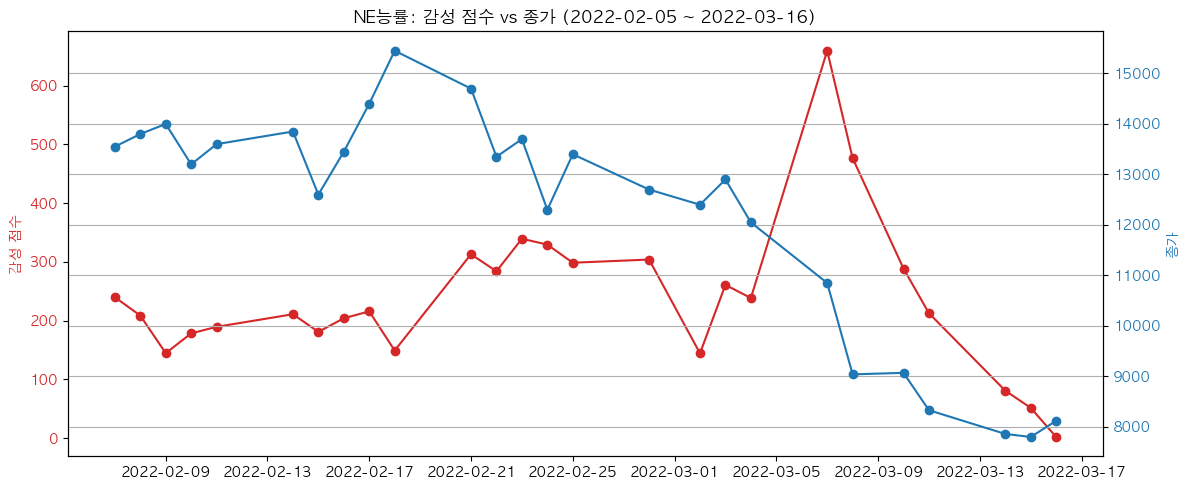

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_4255/2845004644.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  0.6892   5.3692   8.6833  55.8854  28.155    3.9207  52.5788  84.1488
  40.5154  27.6404   5.2434  31.169   66.6509  19.6413  35.7787   7.0394
  -0.3071  59.7055 118.2166  75.3459  41.9013 117.1372  65.3631  24.194
  29.314    1.3207]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


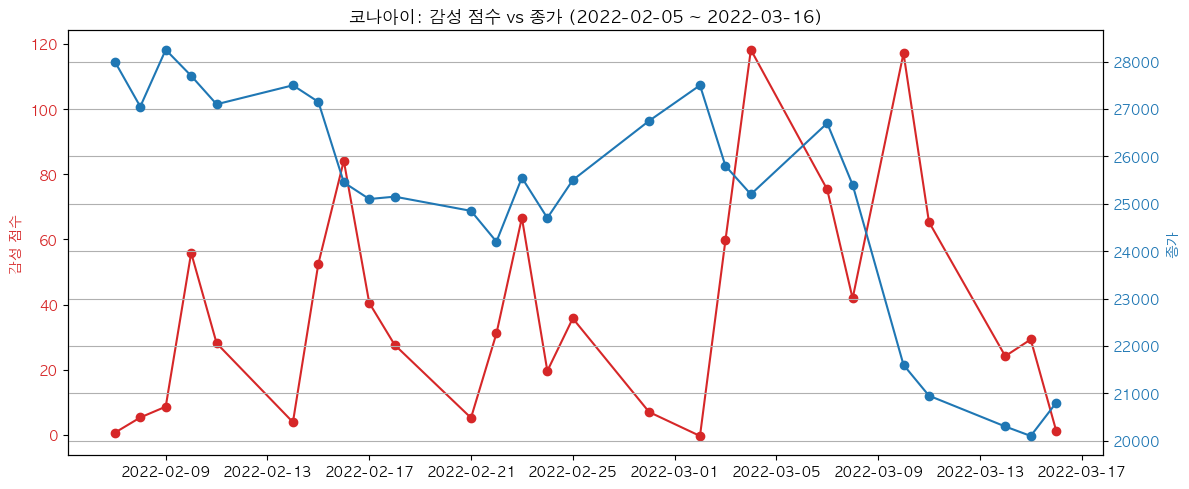

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_4255/2845004644.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.7585 -0.18    0.0797  0.      0.8     0.2052 -0.5519 41.7276  5.4112
 41.6443  0.1896  2.4037  1.2387  0.8194  2.7923  0.1354  0.4905  0.8645
  2.3535  0.9477]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


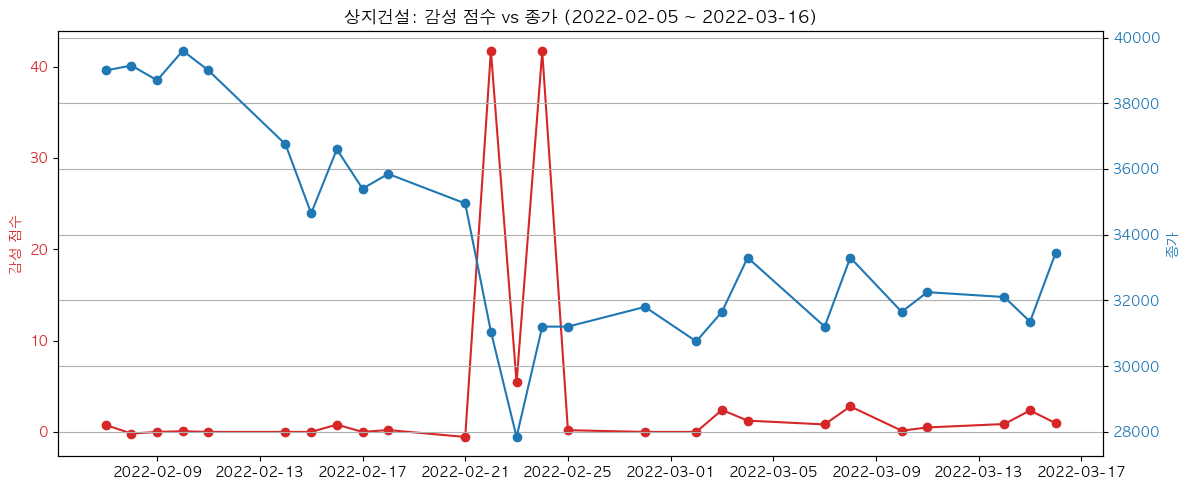

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_4255/2845004644.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[24.7463  5.8333 12.6145 14.1584 18.0908 10.3894 15.1586  4.1132 25.9179
 17.0987  4.1017 12.5241  4.8269  4.7072  4.3481  0.7685  5.6189 18.1517
 12.8338  6.2728  7.672  23.2349  7.3852  1.6092  4.0521  1.6375]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


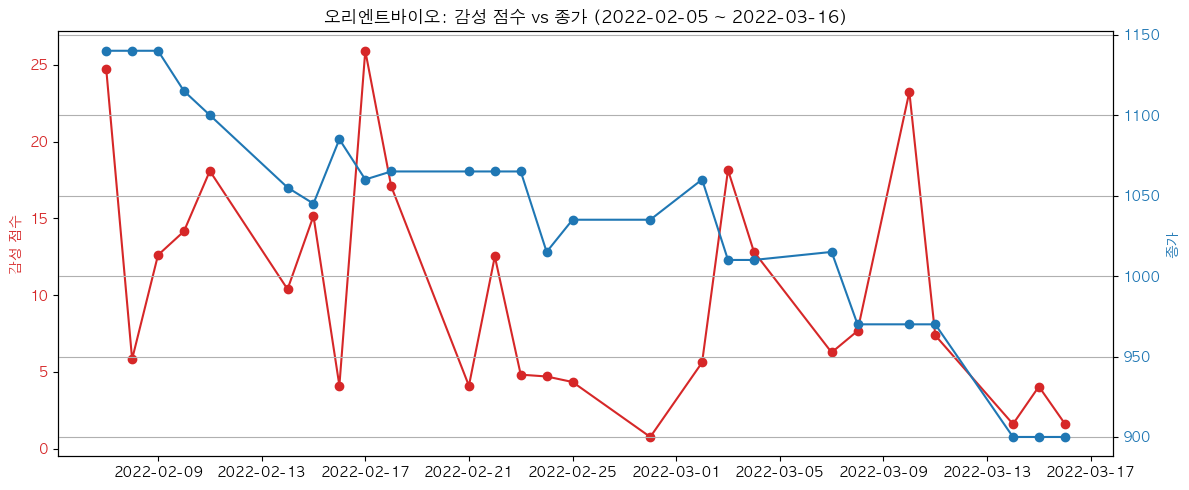

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_4255/2845004644.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 32.7165  65.2058  32.5437  39.2413  60.1459  10.9125   4.5933  18.6896
  33.3614  36.3417  15.9874   9.0083   3.0161  11.8721  34.1175  17.0128
  13.2131  36.7386   9.263   45.0414  20.6372 169.7996 155.0265 257.1746
 236.2461   2.9056]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


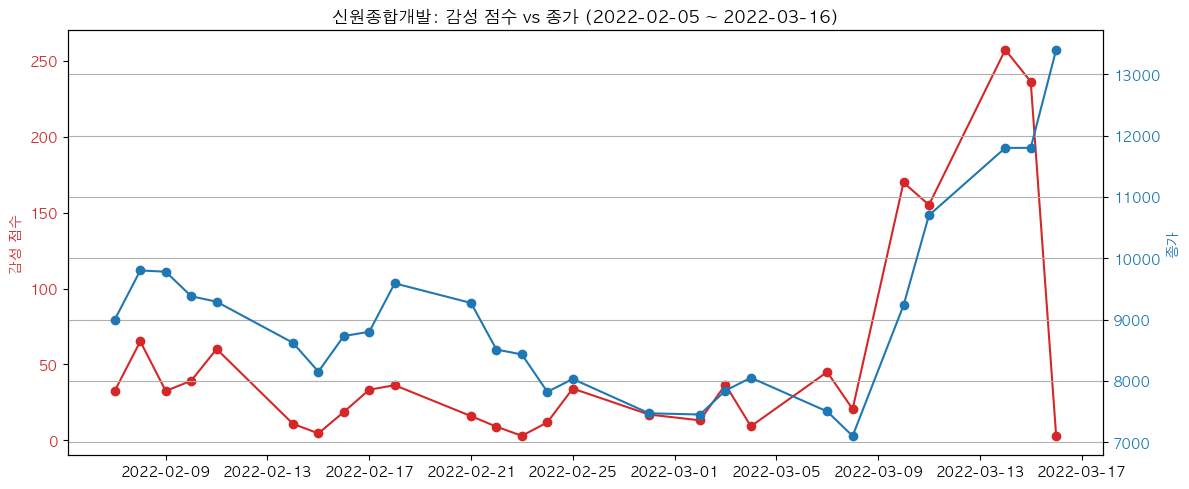

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_4255/2845004644.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[170.5    212.2918 119.8123 207.8769 208.1432 145.2126  54.1436 136.1278
 210.1771 237.8359 212.4296 338.028  215.2121 229.2138 211.051  191.3209
 101.9899 265.7684 201.4932 411.4029 372.0208 248.4277 114.6392  49.8194
  21.1763   2.1318]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


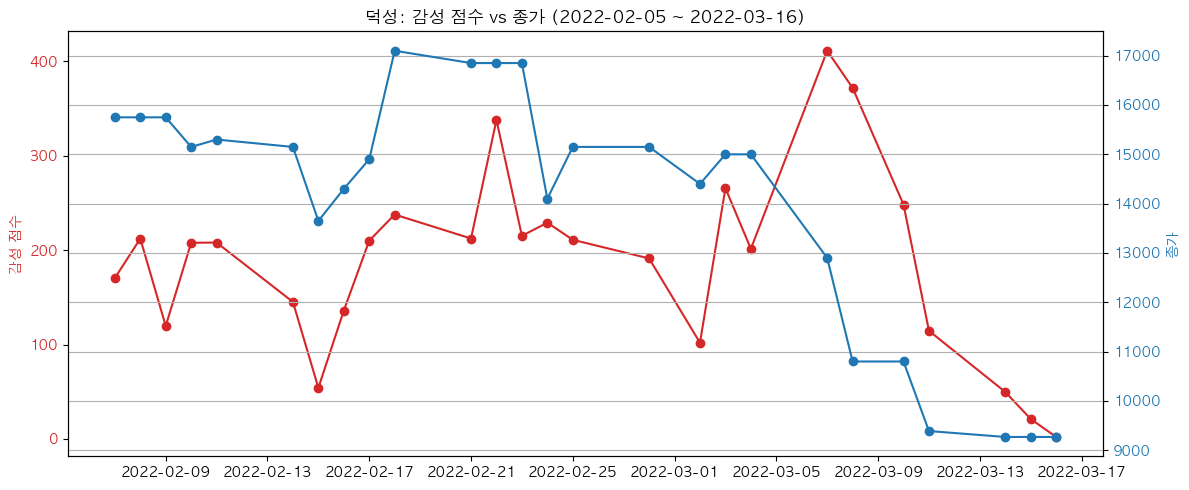

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_4255/2845004644.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 36.7389  55.0433  62.4966  38.1478  94.9183  39.3923  49.5299  28.4404
  54.7919  97.617   29.6527 124.2774  62.3095  50.4573  58.5334  32.1622
  22.1895  91.548   82.1596 149.467   95.1948  94.1228  43.0139  25.9184
  25.8263   1.3471]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


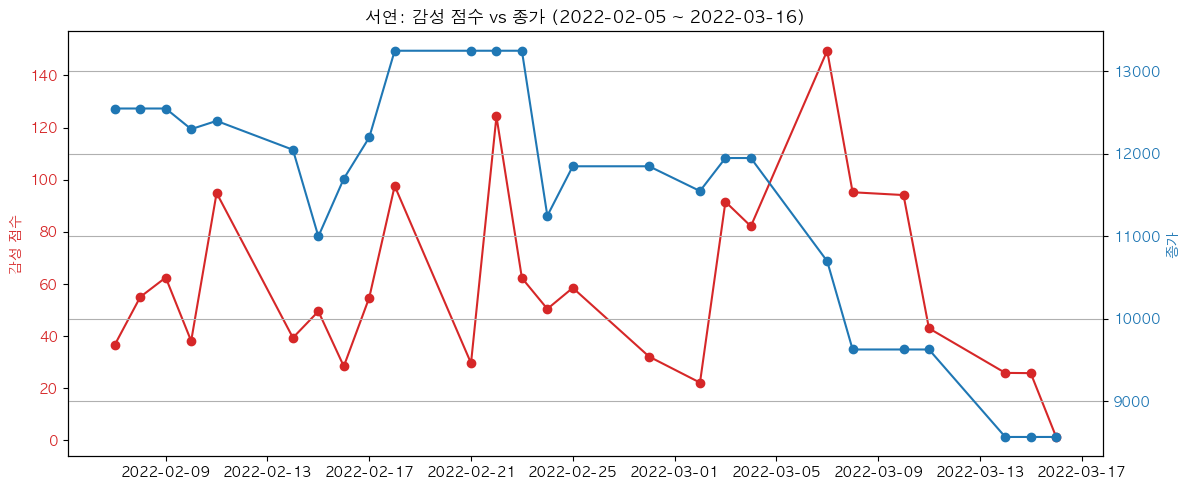

In [ ]:
# ───────────── [3] 감성 점수 + 종가 시각화 ─────────────
for stock_name in all_stock_prices:
    price_df = all_stock_prices[stock_name]
    sentiment_df = all_stock_sentiment.get(stock_name, pd.DataFrame())

    fig, ax1 = plt.subplots(figsize=(12, 5))

    # 감성 점수 시각화 (종가 날짜 기준으로 맞춤)
    filtered_sentiment = sentiment_df[
        (sentiment_df["날짜"] >= FIXED_START) & 
        (sentiment_df["날짜"] <= FIXED_END)
    ]
    base_dates = price_df["Date"]

    # 종가 기준 날짜에 맞춘 감성 점수 매핑 (없으면 0)
    sentiment_series = pd.Series(0, index=base_dates)
    sentiment_series = sentiment_series.astype(float)
    sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])

    # 감성 점수 그래프
    ax1.plot(base_dates, sentiment_series.values, 
             color='tab:red', marker='o', linestyle='-', label="감성 점수")
    ax1.set_ylabel("감성 점수", color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # 종가 그래프
    ax2 = ax1.twinx()
    ax2.plot(price_df["Date"], price_df["Close"],
             color='tab:blue', marker='o', linestyle='-', label="종가")
    ax2.set_ylabel("종가", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # 제목 및 기타 설정
    plt.title(f"{stock_name}: 감성 점수 vs 종가 (2022-02-05 ~ 2022-03-16)")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

In [95]:
# 총 기간은 2022-02-05 ~ 2022-03-16
# 포바이포(이재명 후보 테마주) 출력이 없음
# 확인해보니 종가 데이터 자체가 2022-04-26일부터 시작
# 따라서, 2022-02-05 ~ 2022-03-16 데이터 출력이 불가능함

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_22030/1682697835.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_finance_data["labels"] = df_finance_data["labels"].replace({"neutral": 0, "positive": 1, "negative": 2})


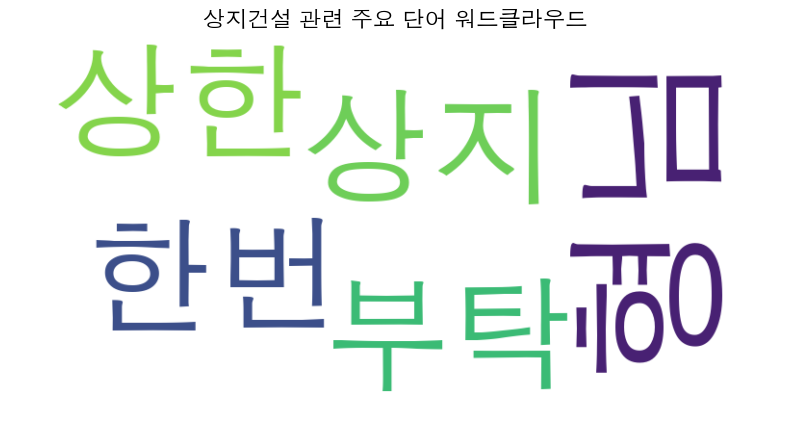

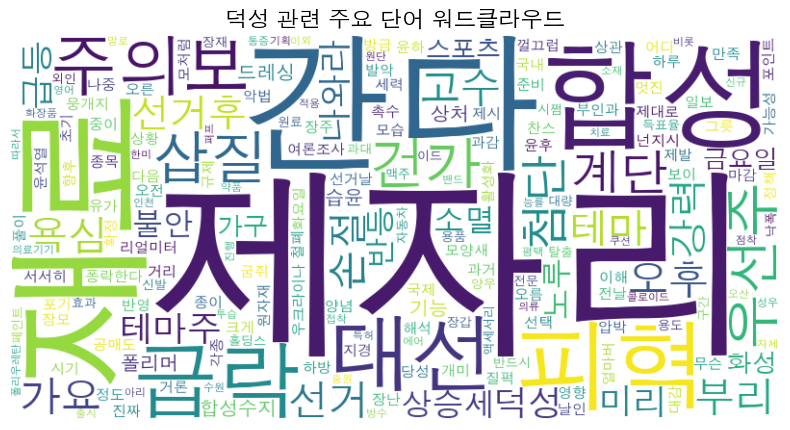

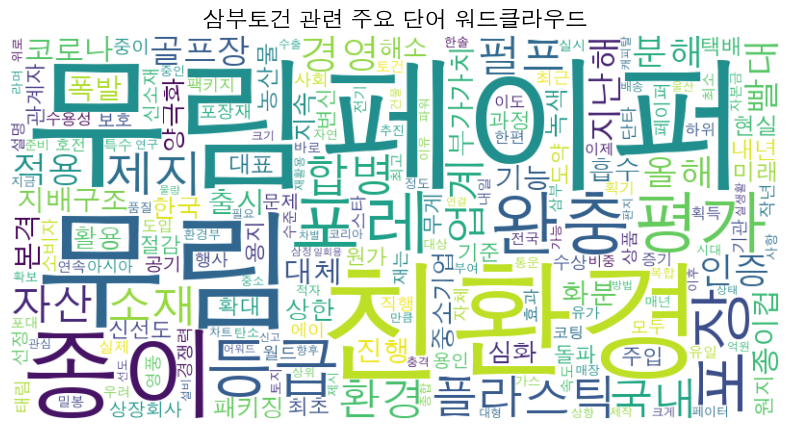

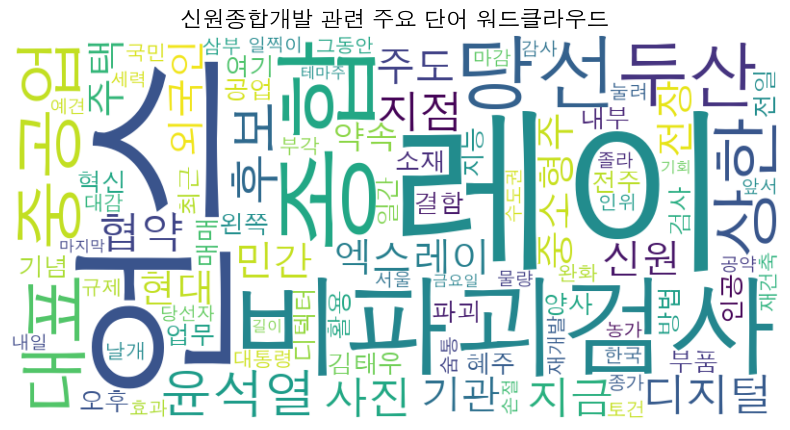

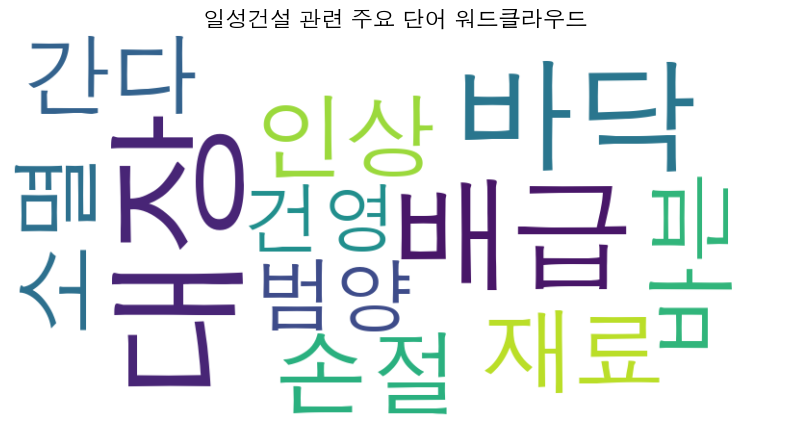

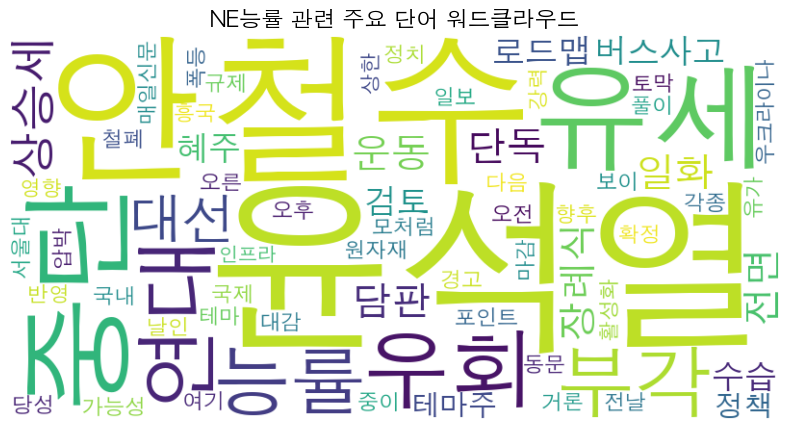

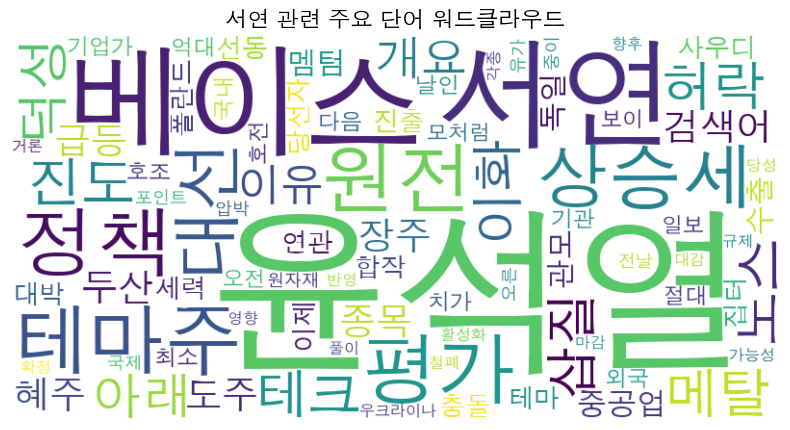

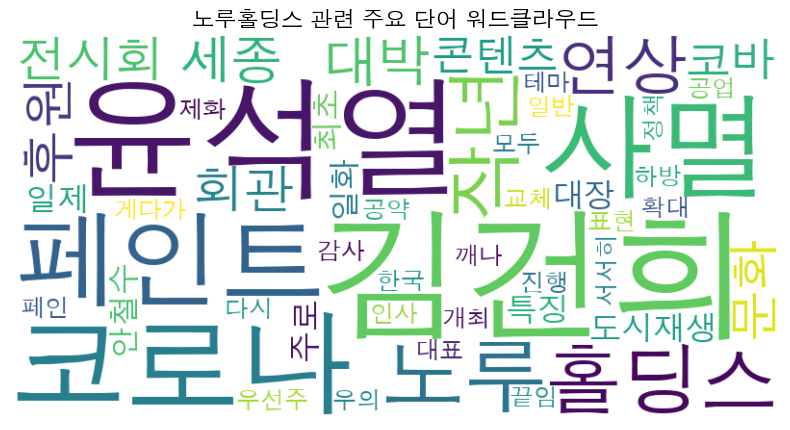

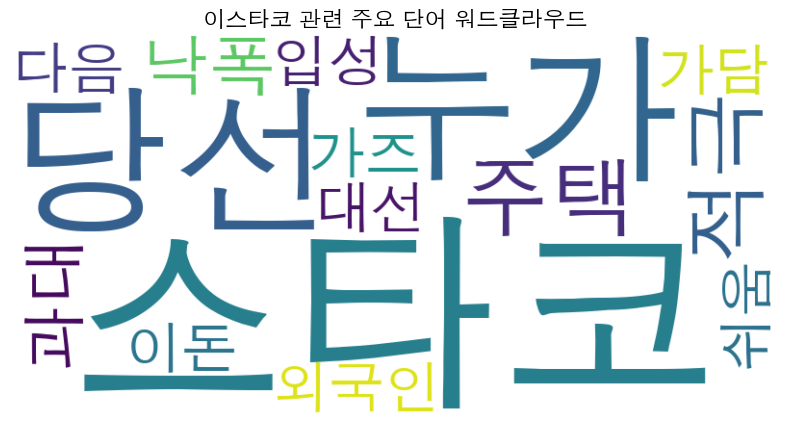

In [97]:
# 데이터 로드
df_finance_data = pd.read_csv("../01_데이터수집/data/finance_data.csv").drop_duplicates(subset=["kor_sentence"])
df_finance_data["labels"] = df_finance_data["labels"].replace({"neutral": 0, "positive": 1, "negative": 2})
texts = df_finance_data["kor_sentence"].tolist()

okt = Okt()

# 불용어 후보 생성 (상위 3% 빈도 단어 + 금융 특화)
all_words = []
for text in texts:
    tokens = okt.pos(text, stem=True)
    all_words.extend([w for w, pos in tokens if pos in ['Noun', 'Adjective', 'Verb'] and len(w) > 1])

counter = Counter(all_words)
top_k = int(len(counter) * 0.03)
high_freq_stopwords = set([w for w, _ in counter.most_common(top_k)])

# 금융 특화 불용어
financial_stopwords = {
    "시장", "주가", "증시", "투자", "매수", "매도", "주식", "증권", 
    "코스피", "코스닥", "기업", "경제", "금융", "지수", "수익", 
    "매출", "실적", "전망", "환율", "금리", "거래", "포트폴리오"
}

# 전체 불용어 세트
candidate_stopwords = high_freq_stopwords | financial_stopwords

def generate_wordcloud(df, stock_name, okt, candidate_stopwords):
    text_corpus = ""
    # 해당 종목의 게시글만 추출
    for _, row in df[df["종목명"] == stock_name].iterrows():
        text = f"{row['제목']} {row['내용']}"
        text_corpus += f" {text}"

    # 형태소 분석 (명사 추출)
    nouns = okt.nouns(text_corpus)
    # 불용어 제거
    filtered = [word for word in nouns if word not in candidate_stopwords and len(word) > 1]

    # 빈도 계산
    word_counts = Counter(filtered)
    if not word_counts:
        print(f"'{stock_name}'에 대해 충분한 텍스트가 없어 워드클라우드를 생성할 수 없습니다.")
        return

    # 워드클라우드 생성
    wc = WordCloud(
        font_path="/System/Library/Fonts/AppleGothic.ttf",  # macOS
        width=800, height=400,
        background_color="white"
    )
    wc.generate_from_frequencies(word_counts)

    # 시각화
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{stock_name} 관련 주요 단어 워드클라우드", fontsize=16)
    plt.show()

# 전체 종목에 대해 반복 수행
for stock_name in df["종목명"].unique():
    generate_wordcloud(df, stock_name, okt, candidate_stopwords)